In [ ]:
# 1. Setup
import os, gc, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import scipy.sparse as sp
from scipy.sparse import vstack, hstack
import torch

from sentence_transformers import SparseEncoder, SentenceTransformer, CrossEncoder
from sklearn.decomposition import TruncatedSVD, PCA, IncrementalPCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from nltk.tokenize import word_tokenize
from nltk.metrics import edit_distance
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import plotly.express as px
import re
from collections import Counter

# Jupyter magics
%matplotlib inline
plt.rcParams.update({'figure.figsize':(6,4), 'font.size':12})
%load_ext memory_profiler


Loaded 3000 rows


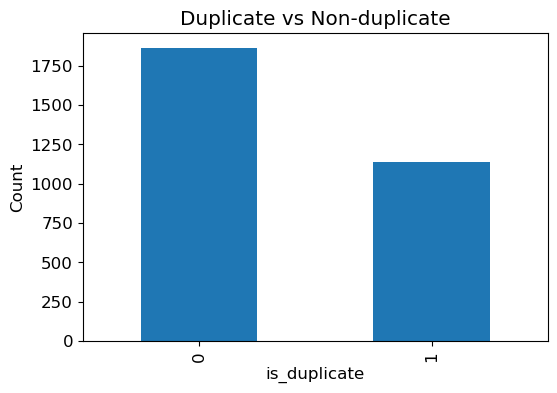

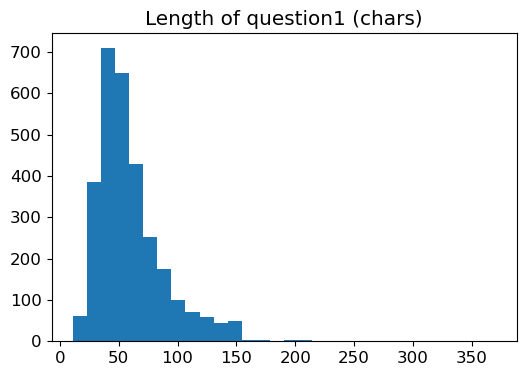

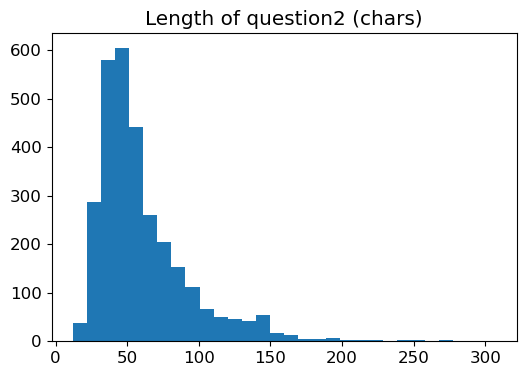

In [ ]:
# 2. Load data & quick visual checks
N = 5000
DATA_PATH = "https://raw.githubusercontent.com/KevorkSulahian/ML_journey/main/random_code/NM/train.csv.zip"

df = pd.read_csv(DATA_PATH, compression="zip").iloc[:N]


# Class balance
df.is_duplicate.value_counts().plot.bar(title="Duplicate vs Non-duplicate")
plt.ylabel("Count"); plt.show()

# Question length distributions
for col in ["question1", "question2"]:
    lens = df[col].astype(str).str.len()
    plt.hist(lens, bins=30)
    plt.title(f"Length of {col} (chars)")
    plt.show()


  0%|          | 0/47 [00:00<?, ?it/s]

SPLADE density: 0.000026


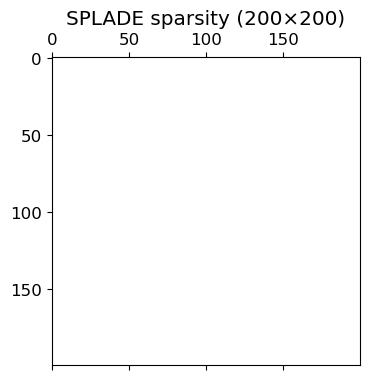

In [6]:
# 3. Sparse SPLADE embeddings (batched) — warning suppressed & trust_remote_code
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()  # ↓ mute that BertForMaskedLM warning

device = "cuda" if torch.cuda.is_available() else "cpu"

# pass trust_remote_code so HF knows it's safe to use the remote code for this model
sparse_model = SparseEncoder(
    "naver/splade-cocondenser-ensembledistil",
    device=device,
    trust_remote_code=True
)

def get_sparse_csr(sentences, model, batch_size=128, topk=None):
    """
    Encodes `sentences` in batches into a SciPy CSR matrix.
    Optionally keeps only the top-k nonzeros per batch-chunk.
    """
    chunks = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch = sentences[i : i + batch_size]
        emb = model.encode(batch, batch_size=batch_size, convert_to_numpy=False)
        coo = emb.coalesce()
        rows, cols = coo.indices()[0].cpu().numpy(), coo.indices()[1].cpu().numpy()
        vals       = coo.values().cpu().numpy()

        if topk:
            # keep only the top-k values *per chunk*
            # (for a strict per-row topk you'd need a bit more logic)
            idx = np.argsort(vals)[-topk:]
            rows, cols, vals = rows[idx], cols[idx], vals[idx]

        chunk = sp.coo_matrix((vals, (rows, cols)), shape=coo.shape).tocsr()
        chunks.append(chunk)

        # cleanup
        del emb, coo, rows, cols, vals
        torch.cuda.empty_cache()

    return vstack(chunks)

# build the flat list and get your full sparse matrix
flat   = [q for pair in zip(df.question1, df.question2) for q in pair]
full_sp = get_sparse_csr(flat, sparse_model, batch_size=128, topk=100)
s1, s2 = full_sp[:N], full_sp[N:]

# Sparsity diagnostics
density = full_sp.nnz / (full_sp.shape[0] * full_sp.shape[1])
print(f"SPLADE density: {density:.6f}")

# plt.spy(full_sp[:200, :200], markersize=1)
# plt.title("SPLADE sparsity (200×200)")
# plt.show()


In [ ]:
# get all (row, col) coords of non-zeros
rows, cols = full_sp.nonzero()

# show a random 1% subsample so it renders fast
sel = np.random.rand(len(rows)) < 0.01
plt.figure(figsize=(6,4))
plt.scatter(cols[sel], rows[sel], s=0.5, alpha=0.1)
plt.xlabel("Feature index")
plt.ylabel("Sentence index")
plt.title("SPLADE non-zero pattern (1% sample)")
plt.show()


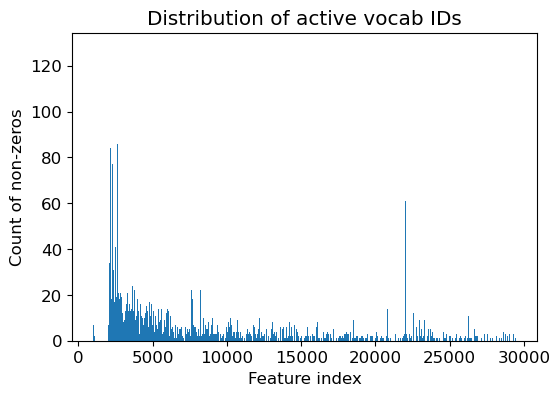

In [9]:
plt.figure(figsize=(6,4))
plt.hist(cols, bins=1000)
plt.xlabel("Feature index")
plt.ylabel("Count of non-zeros")
plt.title("Distribution of active vocab IDs")
plt.show()


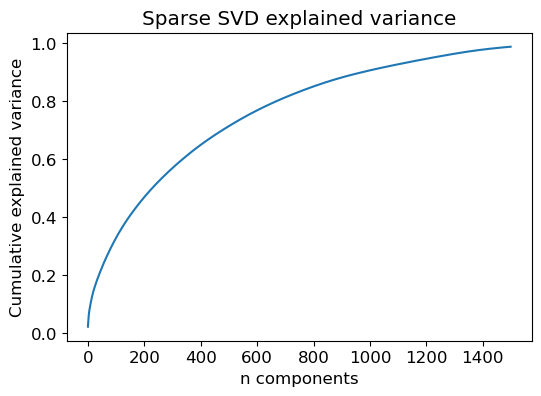

In [14]:
# 4. Dimensionality reduction on sparse
svd = TruncatedSVD(n_components=1500, random_state=42)
X_sp_red = svd.fit_transform(hstack([abs(s1-s2), s1.multiply(s2)]))

explained = svd.explained_variance_ratio_
plt.plot(np.cumsum(explained))
plt.xlabel("n components")
plt.ylabel("Cumulative explained variance")
plt.title("Sparse SVD explained variance"); plt.show()


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

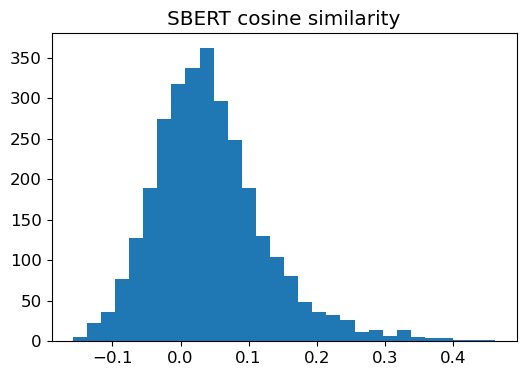

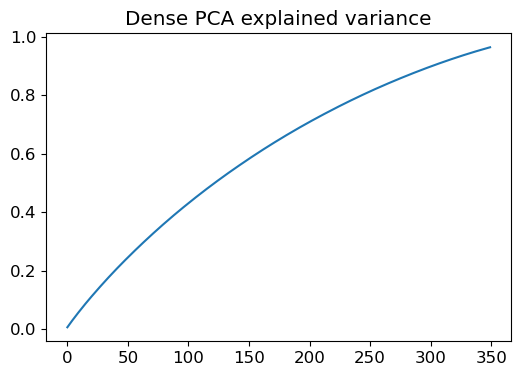

In [18]:
# 5. Dense SBERT embeddings
dense_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
emb_dense = dense_model.encode(flat, batch_size=64, convert_to_numpy=True, show_progress_bar=True)
d1, d2 = emb_dense[:N], emb_dense[N:]

# Cosine‐sim distribution
cosims = np.diag(cosine_similarity(d1, d2))
plt.hist(cosims, bins=30)
plt.title("SBERT cosine similarity"); plt.show()

# PCA on dense diffs
pca = PCA(n_components=350, random_state=42)
X_dn_red = pca.fit_transform(np.hstack([np.abs(d1-d2), d1*d2]))
explained = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained))
plt.title("Dense PCA explained variance"); plt.show()


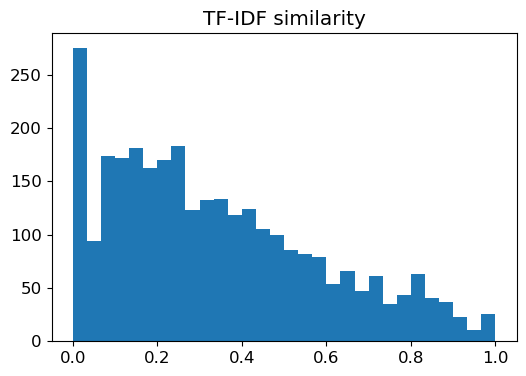

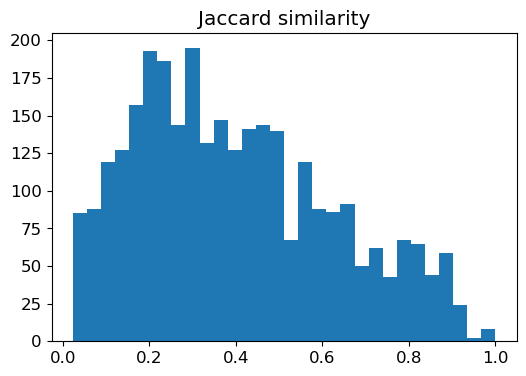

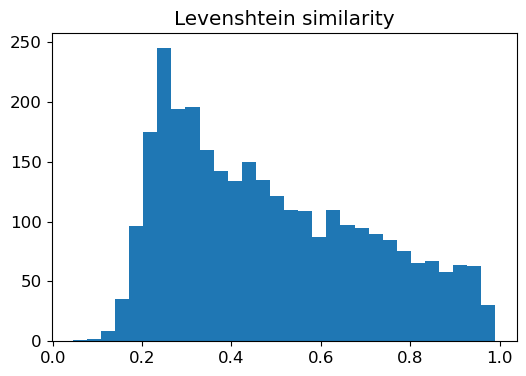

In [19]:
# 6. TF-IDF & simple metrics
all_qs = df.question1.tolist() + df.question2.tolist()
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
tfidf.fit(all_qs)
v1, v2 = tfidf.transform(df.question1), tfidf.transform(df.question2)
tfidf_sim = cosine_similarity(v1, v2, dense_output=False).diagonal()

# Jaccard & Levenshtein
jacc, lev = [], []
for q1,q2 in zip(df.question1, df.question2):
    t1,t2 = set(word_tokenize(str(q1).lower())), set(word_tokenize(str(q2).lower()))
    jacc.append(len(t1&t2)/(len(t1|t2)+1e-8))
    ed = edit_distance(str(q1), str(q2))
    lev.append(1 - ed/max(len(q1), len(q2),1))
jacc, lev = np.array(jacc), np.array(lev)

# Plot distributions
for arr,name in [(tfidf_sim,"TF-IDF"),(jacc,"Jaccard"),(lev,"Levenshtein")]:
    plt.hist(arr, bins=30)
    plt.title(f"{name} similarity")
    plt.show()


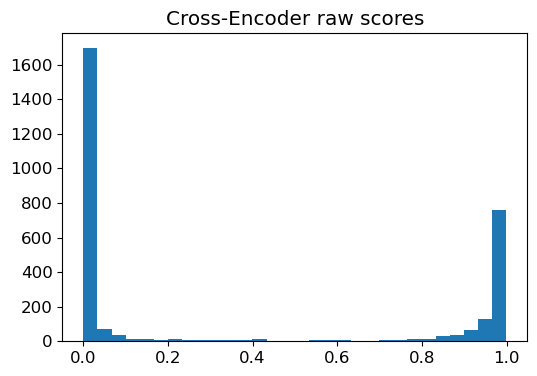

In [20]:
# 7. Cross-Encoder features
xe_model = CrossEncoder("cross-encoder/quora-distilroberta-base", device=device, num_labels=1)
scores = xe_model.predict(list(zip(df.question1, df.question2)), batch_size=32)
xe_feat = (scores - scores.min())/(scores.max()-scores.min())

plt.hist(scores, bins=30)
plt.title("Cross-Encoder raw scores"); plt.show()


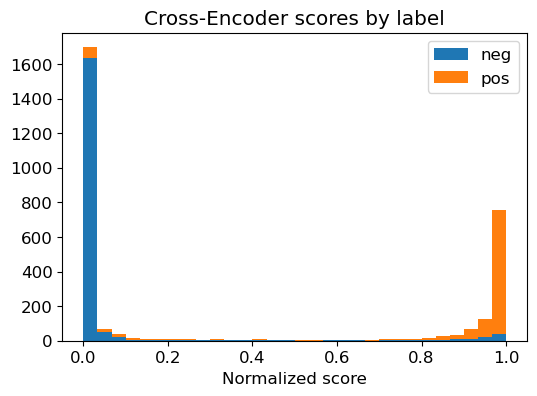

In [23]:
neg = xe_feat[df.is_duplicate == 0]
pos = xe_feat[df.is_duplicate == 1]

plt.hist([neg, pos], bins=30, stacked=True, label=["neg","pos"])
plt.title("Cross-Encoder scores by label")
plt.xlabel("Normalized score")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Cross-Encoder as standalone
auc_xe = roc_auc_score(y, xe_feat)

# Your stacking model
stack.fit(X, y)
preds_stack = stack.predict_proba(X)[:,1]
auc_stack = roc_auc_score(y, preds_stack)

print("XE AUC:", auc_xe)
print("Stacked AUC:", auc_stack)


In [25]:
# 8. Assemble features
X = np.hstack([
    X_sp_red,
    X_dn_red,
    tfidf_sim.reshape(-1,1),
    jacc.reshape(-1,1),
    lev.reshape(-1,1),
    xe_feat.reshape(-1,1),
])
y = df.is_duplicate.values

print("X shape:", X.shape)
%memit _ = X.copy()


X shape: (3000, 1854)
peak memory: 2031.88 MiB, increment: 42.45 MiB


In [ ]:
# 9. Modeling
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 9.2 Hyperparameter space
param_dist = {
    'n_estimators':     [100, 200, 400],
    'max_depth':        [3, 6, 9],
    'learning_rate':    [0.01, 0.05, 0.1],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, y.sum()/(len(y)-y.sum())]
}

# 9.3 Base classifier (no predictor/use_label_encoder)
xgb_base = XGBClassifier(
    device= "cuda",
    eval_metric = "auc",
    random_state= 42
)

# 9.4 Randomized search (single-threaded)
rs = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=CV,
    n_jobs=1,
    random_state=42,
    verbose=2
)

# 9.5 Run search
t0 = time.time()
rs.fit(X, y)
print(f"Search time: {time.time() - t0:.1f}s")
print("Best AUC:", rs.best_score_)
print("Best params:", rs.best_params_)

# 9.6 Build stacking ensemble
best_params = rs.best_params_
tree_method = "gpu_hist" if device=="cuda" else "hist"
device_arg  = "cuda"     if device=="cuda" else "cpu"

estimators = [
    ("lr", LogisticRegression(max_iter=1000, random_state=42)),
    ("xgb", XGBClassifier(
        **best_params,
        tree_method=tree_method,
        device=device_arg,
        eval_metric="auc",
        random_state=42
    ))
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(
        n_estimators=100,
        tree_method=tree_method,
        device=device_arg,
        eval_metric="auc",
        random_state=42
    ),
    cv=CV,
    n_jobs=-1,
    passthrough=False
)

# 9.7 Fit & evaluate stacking
stack.fit(X, y)
probs = stack.predict_proba(X)[:, 1]




Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.6; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.6; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.6; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=200, scale_pos_weight=1, subsample=0.6; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=200, scale_pos_weight=0.6094420600858369, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=200, scale_pos_weight=0.60944

c:\Users\kevor\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:39:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kevor\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [00:39:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


NameError: name 'roc_auc_score' is not defined

In [33]:
from sklearn.metrics import roc_auc_score

print(f"Stacked model ROC-AUC: {roc_auc_score(y, probs):.4f}")

Stacked model ROC-AUC: 0.9929
